# Eksplorasi dan Pemodelan untuk Deteksi Anomali DNS

Tujuan notebook ini adalah untuk:
1. Memuat dan memahami data log DNS.
2. Melakukan feature engineering untuk mengekstrak sinyal dari data.
3. Melatih model Isolation Forest untuk mendeteksi anomali.
4. Menganalisis hasil deteksi.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import fungsi dari file utils kita
import sys
sys.path.append('../src')
from analysis_utils import feature_engineering, train_and_predict, calculate_entropy

# Atur style plot
sns.set_theme(style="whitegrid")

In [2]:
# Muat data dari file CSV yang sudah dikembangkan
# Pastikan Anda sudah mengganti file lama dengan yang baru.
df = pd.read_csv('../data/dns_log.csv')

print("Informasi Data Awal:")
df.info()

print("\nPratinjau Data:")
df.head()

Informasi Data Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      53 non-null     object 
 1   source_ip      53 non-null     object 
 2   query_name     53 non-null     object 
 3   tld            53 non-null     object 
 4   numeric_ratio  53 non-null     float64
 5   has_hyphen     53 non-null     int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 2.6+ KB

Pratinjau Data:


,timestamp,source_ip,query_name,tld,numeric_ratio,has_hyphen
0,2025-06-14T15:10:01,10.151.34.12,integra.its.ac.id,ac.id,0.0,0
1,2025-06-14T15:10:02,10.151.35.88,google.com,com,0.0,0
2,2025-06-14T15:10:03,10.151.34.12,akademik.its.ac.id,ac.id,0.0,0
3,2025-06-14T15:10:04,10.151.36.21,github.com,com,0.0,0
4,2025-06-14T15:10:05,10.151.34.12,my.its.ac.id,ac.id,0.0,0


## 2. Feature Engineering
Kita akan menambahkan fitur-fitur yang sudah kita definisikan (`query_length`, `query_entropy`, `subdomain_count`) menggunakan fungsi dari `analysis_utils`.

In [3]:
# --- FEATURE ENGINEERING ---

# 1. Buat fitur dari fungsi yang sudah ada (jika belum ada di CSV)
# Ini memastikan konsistensi bahkan jika CSV tidak memiliki fitur ini
df_featured = df.copy()
df_featured['query_length'] = df_featured['query_name'].str.len()
df_featured['query_entropy'] = df_featured['query_name'].apply(calculate_entropy)
df_featured['subdomain_count'] = df_featured['query_name'].str.count('\\.')

# 2. Lakukan One-Hot Encoding pada fitur kategorikal 'tld'
df_featured = pd.get_dummies(df_featured, columns=['tld'], prefix='tld')

print("Data dengan Fitur Baru dan Encoding:")
# Tampilkan beberapa kolom terakhir untuk melihat hasil encoding
df_featured.tail()

Data dengan Fitur Baru dan Encoding:


,timestamp,source_ip,query_name,numeric_ratio,has_hyphen,query_length,query_entropy,subdomain_count,tld_ac.id,tld_bin,...,tld_io,tld_net,tld_online,tld_org,tld_ru,tld_sh,tld_site,tld_support,tld_top,tld_xyz
48,2025-06-14T15:12:11,10.151.39.77,netflix.com-login.biz,0.000000,1,21,3.784942,2,False,False,...,False,False,False,False,False,False,False,False,False,False
49,2025-06-14T15:12:12,10.151.36.81,researchgate.net,0.000000,0,16,3.125000,1,False,False,...,False,True,False,False,False,False,False,False,False,False
50,2025-06-14T15:12:13,10.151.40.1,j9s8h3g2f1d0s9a8l.info,0.230769,0,22,4.095795,1,False,False,...,False,False,False,False,False,False,False,False,False,False
51,2025-06-14T15:12:14,10.151.37.49,auth.garena.com,0.000000,0,15,3.456565,2,False,False,...,False,False,False,False,False,False,False,False,False,False
52,2025-06-14T15:12:15,10.151.38.112,ZmFrZS1wYXlsb2FkLWZpbGUud2FybmluZy5leGU.data,0.000000,0,44,4.589780,1,False,False,...,False,False,False,False,False,False,False,False,False,False


## 3. Eksplorasi Data (EDA)
Mari kita visualisasikan fitur-fitur baru untuk melihat apakah anomali terlihat menonjol.

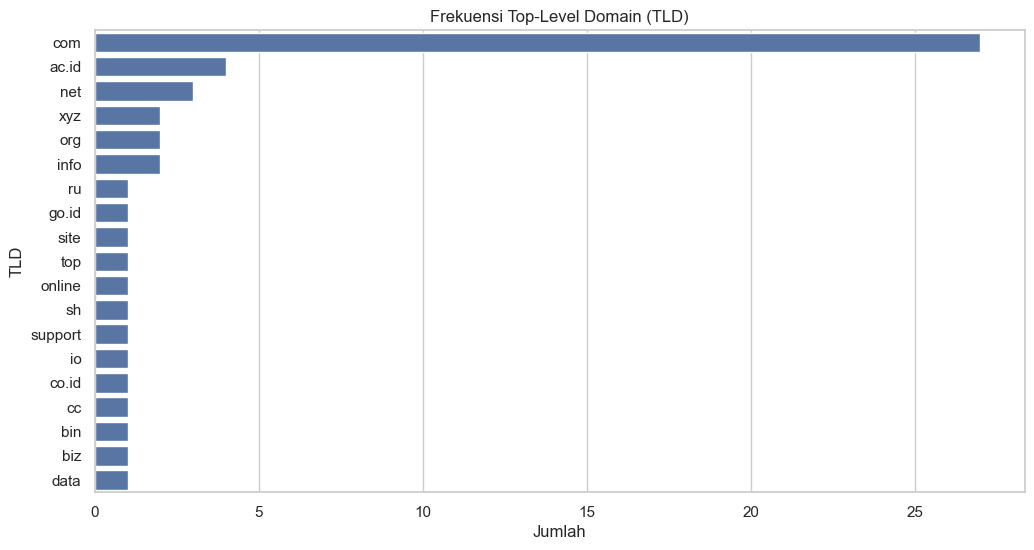

In [4]:
# --- EKSPLORASI DATA (EDA) ---

# Visualisasi distribusi TLD
plt.figure(figsize=(12, 6))
# Kita gunakan kolom 'tld' dari dataframe asli sebelum di-encode
sns.countplot(y=df['tld'], order=df['tld'].value_counts().index)
plt.title('Frekuensi Top-Level Domain (TLD)')
plt.xlabel('Jumlah')
plt.ylabel('TLD')
plt.show()

# Visualisasi ini membantu kita melihat TLD yang umum dan yang jarang muncul (potensi anomali)

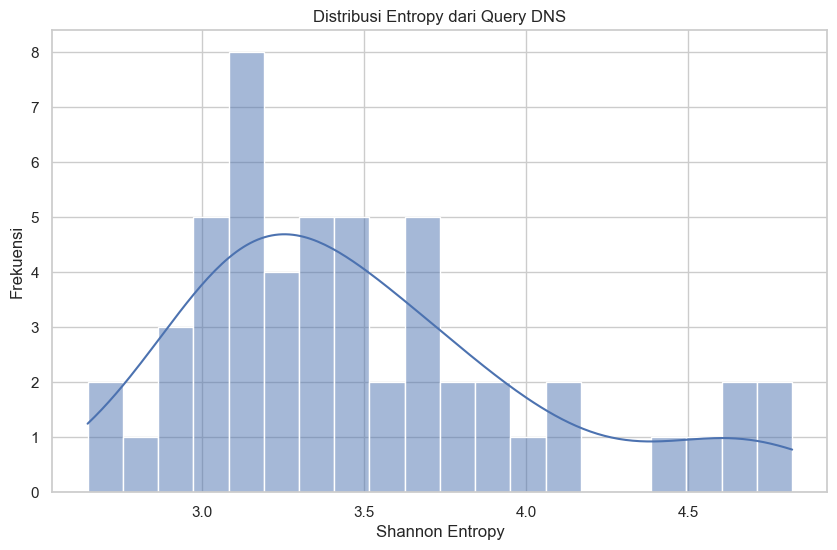

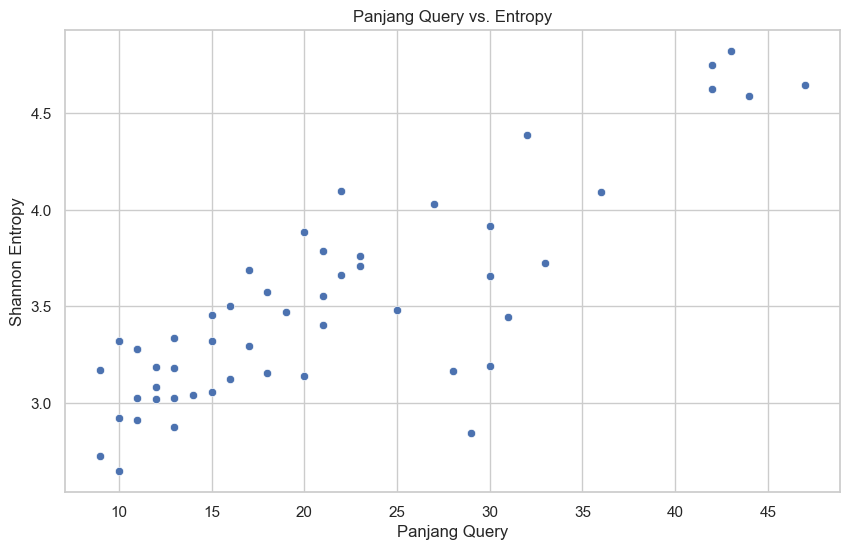

In [5]:
# (Kode dari sel 7 & 8 di notebook asli tidak perlu diubah)
# Visualisasi distribusi entropy
plt.figure(figsize=(10, 6))
sns.histplot(df_featured['query_entropy'], bins=20, kde=True)
plt.title('Distribusi Entropy dari Query DNS')
plt.xlabel('Shannon Entropy')
plt.ylabel('Frekuensi')
plt.show()

# Visualisasi panjang query vs entropy
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_featured, x='query_length', y='query_entropy')
plt.title('Panjang Query vs. Entropy')
plt.xlabel('Panjang Query')
plt.ylabel('Shannon Entropy')
plt.show()

## 4. Pemodelan dan Deteksi
Sekarang kita latih model `IsolationForest` dan lihat apa yang dideteksinya.

In [6]:
# --- PEMODELAN DAN DETEKSI ---

# 1. Tentukan kolom fitur yang akan digunakan untuk model
# Kita akan gunakan semua kolom numerik kecuali yang merupakan identifier
feature_cols = df_featured.select_dtypes(include=np.number).columns.tolist()

# (Opsional) Hapus kolom yang tidak relevan jika ada, contoh:
# if 'kolom_id' in feature_cols:
#     feature_cols.remove('kolom_id')

print(f"Fitur yang digunakan untuk model ({len(feature_cols)}):")
print(feature_cols)


# 2. Latih model dan dapatkan prediksi
predictions = train_and_predict(df_featured, feature_cols)
df_featured['is_anomaly'] = predictions


# 3. Tampilkan hasil deteksi
anomalies = df_featured[df_featured['is_anomaly'] == -1]

print("\n--- ANOMALI TERDETEKSI ---")
# Tampilkan kolom-kolom yang paling informatif
display_cols = ['timestamp', 'source_ip', 'query_name', 'query_entropy', 'numeric_ratio', 'has_hyphen', 'subdomain_count']
print(anomalies[display_cols])

Fitur yang digunakan untuk model (5):
['numeric_ratio', 'has_hyphen', 'query_length', 'query_entropy', 'subdomain_count']

--- ANOMALI TERDETEKSI ---
              timestamp      source_ip  \
4   2025-06-14T15:10:05   10.151.34.12   
6   2025-06-14T15:10:07   10.151.37.10   
10  2025-06-14T15:10:11   10.151.38.44   
11  2025-06-14T15:10:12   10.151.34.12   
13  2025-06-14T15:10:14   10.151.39.50   
15  2025-06-14T15:10:16   10.151.40.11   
23  2025-06-14T15:11:06   10.151.37.10   
24  2025-06-14T15:11:07   10.151.39.50   
25  2025-06-14T15:11:08   10.151.38.44   
26  2025-06-14T15:11:09   10.151.40.11   
27  2025-06-14T15:11:10   10.151.39.50   
28  2025-06-14T15:11:11   10.151.35.88   
30  2025-06-14T15:11:13   10.151.34.12   
33  2025-06-14T15:11:16   10.151.40.11   
34  2025-06-14T15:11:17   10.151.39.50   
35  2025-06-14T15:11:18   10.151.37.10   
37  2025-06-14T15:11:20   10.151.38.44   
42  2025-06-14T15:12:05  10.151.38.112   
43  2025-06-14T15:12:06   10.151.39.77   
44  2025-0